# <center>Training CycleGAN with Tensorflow and OpenCV<center>  

# Horses vs zebra

In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import time
print(tf.__version__)

2.6.2


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
# Preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory and equalize 
def load_images(path, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        hsv_pixels = cv2.cvtColor(pixels, cv2.COLOR_RGB2HSV)
        hsv_pixels[:,:,2] = cv2.equalizeHist(hsv_pixels[:,:,2].astype(np.uint8))
        pixels = cv2.cvtColor(hsv_pixels, cv2.COLOR_HSV2RGB)
        # store
        data_list.append(pixels)
    return asarray(data_list)

# # Processing and saving files will be done only once then commented 
# # dataset path
# path = 'I://GAN_DATA//horse2zebra//'
# # load dataset A
# dataA1 = load_images(path + 'trainA/')
# dataAB = load_images(path + 'testA/')
# dataA = vstack((dataA1, dataAB))
# print('Loaded dataA: ', dataA.shape)
# # load dataset B
# dataB1 = load_images(path + 'trainB/')
# dataB2 = load_images(path + 'testB/')
# dataB = vstack((dataB1, dataB2))
# print('Loaded dataB: ', dataB.shape)
# # save as compressed numpy array
# filename = 'I://GAN_DATA//horse2zebra_256.npz'
# savez_compressed(filename, dataA, dataB)
# print('Saved dataset: ', filename)

Loaded:  (1187, 256, 256, 3) (1474, 256, 256, 3)


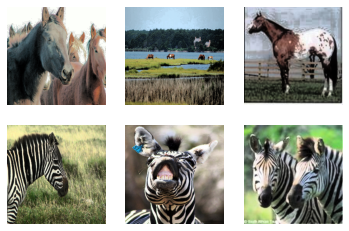

In [4]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('I://GAN_DATA//horse2zebra_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [5]:
# weighted sum output
class WeightedSum(tf.keras.layers.Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')
 
    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

In [6]:
# mini-batch standard deviation layer
class MinibatchStdev(tf.keras.layers.Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)
 
    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-10
        # square root of the variance (stdev)
        stdev = backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = backend.concatenate([inputs, output], axis=-1)
        return combined
 
    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

In [7]:
# pixel-wise feature vector normalization layer
class PixelNormalization(tf.keras.layers.Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)
 
    # perform the operation
    def call(self, inputs):
        # calculate square pixel values
        values = inputs**2.0
        # calculate the mean pixel values
        mean_values = backend.mean(values, axis=-1, keepdims=True)
        # ensure the mean is not zero
        mean_values += 1.0e-10
        # calculate the sqrt of the mean squared value (L2 norm)
        l2 = backend.sqrt(mean_values)
        # normalize values by the l2 norm
        normalized = inputs / l2
        return normalized
 
    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape

Functions and configuration : 

In [8]:
from tensorflow_addons.layers.normalizations import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)

Discriminator : 

In [9]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.000005, beta_1=0.8), loss_weights=[0.5])
    return model

Generator : 

In [10]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

In [11]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    
    return model

Optimizer : 

Model : 

In [34]:
# define a composite model for updating generators by adversarial and cycle loss
from mtadam import MTAdam

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(learning_rate=0.00001, beta_1=0.8, beta_2=0.99, epsilon=1e-9,
               amsgrad=False)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[2, 5, 10, 10], optimizer=opt)
    return model

Losses : 

Sample Generation : 

In [13]:
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [14]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [15]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [16]:
# save the generator models to file
def save_models(step, d_model_A, d_model_B, g_model_AtoB, g_model_BtoA):
    filename1 = 'd_model_A_%06d.h5' % (step)
    d_model_A.save(filename1)
    # save the second discriminator model
    filename2 = 'd_model_B_%06d.h5' % (step)
    d_model_B.save(filename2)
    # save the first generator model
    filename3 = 'g_model_AtoB_%06d.h5' % (step)
    g_model_AtoB.save(filename3)
    # save the second generator model
    filename4 = 'g_model_BtoA_%06d.h5' % (step)
    g_model_BtoA.save(filename4)
    # save the first discriminator model   
    print('>Saved: %s, %s, %s and %s' % (filename1, filename2, filename3, filename4))

In [17]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [18]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

#### Training : 

Training preparation : 

In [35]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow_addons.layers import InstanceNormalization
from matplotlib import pyplot

# load image data
dataset = load_real_samples('I://GAN_DATA//horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
# train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)


Training function : 

In [37]:
# Transform train_on_batch return value
# to dict expected by on_batch_end callback
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result

# train cyclegan models

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, n_epochs=10, initial_epochs=0):
    # define properties of the training run
    n_batch = 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * ( n_epochs )
    # initiate losses follow-up dict
    ordered_losses_dict = {}
    epoch_losses = epoch_avg_losses = [0,0,0,0,0,0]
    # initiate TB monitor
    tensorboards = {}
    models = [d_model_A, d_model_A, d_model_B, d_model_B, c_model_AtoB, c_model_BtoA]
    model_names = ['d_model_A_loss1', 'd_model_A_loss2', 'd_model_B_loss1', 'd_model_B_loss2', 'c_model_AtoB', 'c_model_BtoA']
    for num, j in enumerate(models):
        tensorboards[num] = keras.callbacks.TensorBoard(
            log_dir='C://Users//Wince//Downloads//OC//Hors-Projets//GAN//OPT_MODEL_1//Monitor//' + f'{model_names[num]}//',
            histogram_freq=0,
            batch_size=n_batch,
            write_graph=True,
            write_grads=True
        )
        tensorboards[num].set_model(j) 
        tensorboards[num].on_train_begin(None)
    # manually enumerate train steps
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1 = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # # summarize losses for batched image
        # print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1[0],g_loss2[0]))
        # record loss
        ordered_losses_dict[i] = [[dA_loss1], [dA_loss2], [dB_loss1], [dB_loss2], g_loss1, g_loss2]
        # for ind, z in enumerate(epoch_losses):
        #     z += ordered_losses_dict[i][ind]
        for n in range(len(ordered_losses_dict[i])) : 
            epoch_losses[n] += ordered_losses_dict[i][n][0] 
        # # record loss with TB
        # for j in models : 
        #     tensorboard.on_batch_end(i, named_logs(j, ordered_losses_dict[i]))
        # # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
            # # save the models
            save_models(((i+1)//(bat_per_epo)) + (initial_epochs), d_model_A, d_model_B, g_model_AtoB, g_model_BtoA)
            # save losses
            epoch_avg_losses = [y/bat_per_epo for y in epoch_losses]
            for q,j in enumerate(models) : 
                tensorboards[q].on_epoch_end(((i+1)//(bat_per_epo)) + (initial_epochs), named_logs(j, [epoch_avg_losses[q]]))
            # print losses
            print('\n>>>>>>>>>>>>>>>>>>>>>>>>>>> Epoch %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]\n' % (((i+1)//(bat_per_epo)) + (initial_epochs),
                                                                              epoch_avg_losses[0],
                                                                              epoch_avg_losses[1],
                                                                              epoch_avg_losses[2],
                                                                              epoch_avg_losses[3],
                                                                              epoch_avg_losses[4],
                                                                              epoch_avg_losses[5]
                                                                             )
                 )            
            # reset epoch_losses
            epoch_losses = [0,0,0,0,0,0]
        elif (i) % (bat_per_epo * 1) == 0: 
            for q,j in enumerate(models) : 
                tensorboards[q].on_epoch_begin(((i+1)//(bat_per_epo)) + (initial_epochs), named_logs(j, [epoch_avg_losses[q]]))
    for q in range(len(models)):
        tensorboards[q].on_train_end(None)

Load Tensorboard to follow learning curves : 

In [38]:
%load_ext tensorboard

In [3]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [39]:
%tensorboard --logdir C://Users//Wince//Downloads//OC//Hors-Projets//GAN//OPT_MODEL_1//Monitor//

Load weights for further training on saved model : 

In [36]:
g_model_AtoB.load_weights("C://Users//Wince//Downloads//OC//Hors-Projets//GAN//g_model_AtoB_000060.h5")
g_model_BtoA.load_weights("C://Users//Wince//Downloads//OC//Hors-Projets//GAN//g_model_BtoA_000060.h5")
d_model_A.load_weights("C://Users//Wince//Downloads//OC//Hors-Projets//GAN//d_model_A_000060.h5")
d_model_B.load_weights("C://Users//Wince//Downloads//OC//Hors-Projets//GAN//d_model_B_000060.h5")

Execute training for given epochs : 

In [46]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, initial_epochs=70)

>Saved: d_model_A_000071.h5, d_model_B_000071.h5, g_model_AtoB_000071.h5 and g_model_BtoA_000071.h5

>>>>>>>>>>>>>>>>>>>>>>>>>>> Epoch 71, dA[0.104,0.091] dB[0.103,0.090] g[2.771,2.752]

>Saved: d_model_A_000072.h5, d_model_B_000072.h5, g_model_AtoB_000072.h5 and g_model_BtoA_000072.h5

>>>>>>>>>>>>>>>>>>>>>>>>>>> Epoch 72, dA[0.102,0.089] dB[0.103,0.092] g[2.744,2.750]

>Saved: d_model_A_000073.h5, d_model_B_000073.h5, g_model_AtoB_000073.h5 and g_model_BtoA_000073.h5

>>>>>>>>>>>>>>>>>>>>>>>>>>> Epoch 73, dA[0.104,0.090] dB[0.104,0.090] g[2.753,2.758]

>Saved: d_model_A_000074.h5, d_model_B_000074.h5, g_model_AtoB_000074.h5 and g_model_BtoA_000074.h5

>>>>>>>>>>>>>>>>>>>>>>>>>>> Epoch 74, dA[0.103,0.091] dB[0.102,0.091] g[2.754,2.734]

>Saved: d_model_A_000075.h5, d_model_B_000075.h5, g_model_AtoB_000075.h5 and g_model_BtoA_000075.h5

>>>>>>>>>>>>>>>>>>>>>>>>>>> Epoch 75, dA[0.103,0.091] dB[0.104,0.092] g[2.724,2.706]

>Saved: d_model_A_000076.h5, d_model_B_000076.h5, g_model_AtoB_00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Wince\AppData\Local\Temp\ipykernel_35260\1630194665.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


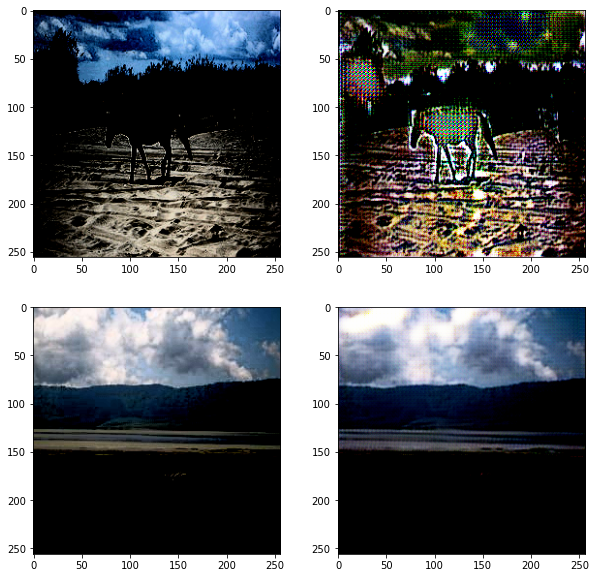

In [28]:
# 10 epochs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
trainA, trainB = dataset
# select a batch of real samples
batch_size = 1
n_patch = d_model_A.output_shape[1]
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

C:\Users\Wince\AppData\Local\Temp\ipykernel_35260\3033486782.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


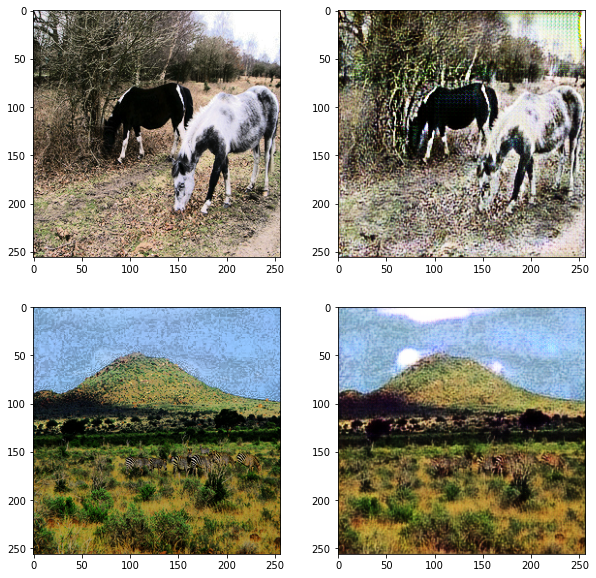

In [33]:
# 30 epochs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
trainA, trainB = dataset
# select a batch of real samples
batch_size = 1
n_patch = d_model_A.output_shape[1]

# Generate real and fake samples
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

# Constrain values from [-1;1] to [0;1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeA = (X_fakeA + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0

# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

C:\Users\Wince\AppData\Local\Temp\ipykernel_35260\1260123838.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


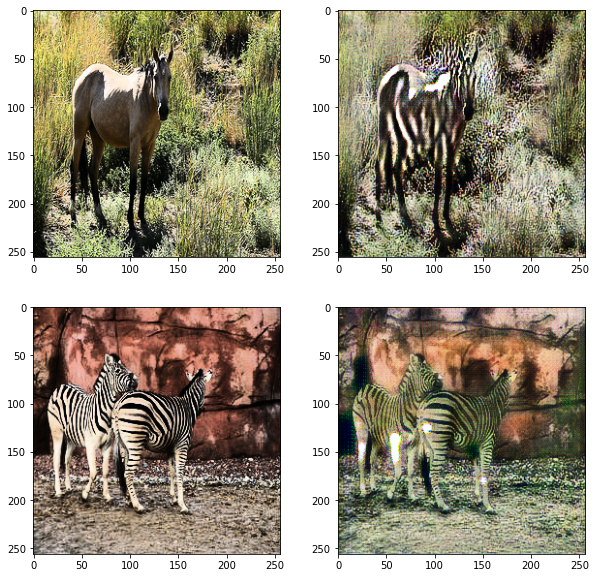

In [37]:
# 50 epochs
# select a batch of real samples
n_patch = d_model_A.output_shape[1]

# Generate real and fake samples
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

# Constrain values from [-1;1] to [0;1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeA = (X_fakeA + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0

# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

C:\Users\Wince\AppData\Local\Temp\ipykernel_35260\2339246033.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


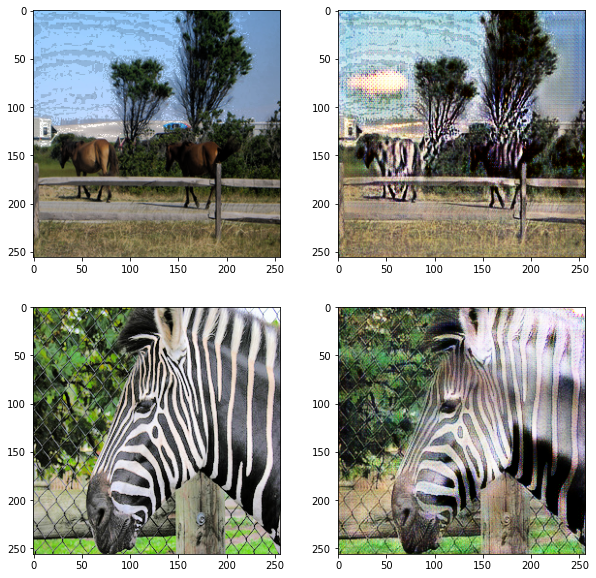

In [39]:
# 60 epochs
# select a batch of real samples
n_patch = d_model_A.output_shape[1]

# Generate real and fake samples
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

# Constrain values from [-1;1] to [0;1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeA = (X_fakeA + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0

# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

C:\Users\Wince\AppData\Local\Temp\ipykernel_15100\207982015.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


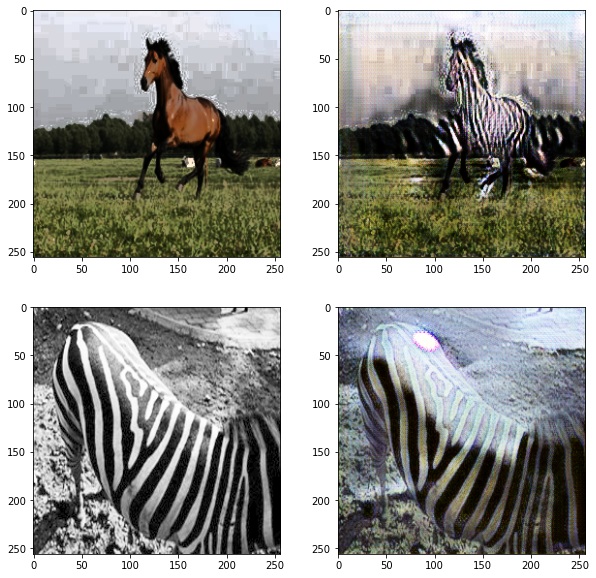

In [45]:
# 70 epochs
# select a batch of real samples
n_patch = d_model_A.output_shape[1]

# Generate real and fake samples
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

# Constrain values from [-1;1] to [0;1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeA = (X_fakeA + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0

# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

C:\Users\Wince\AppData\Local\Temp\ipykernel_15100\4046442362.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


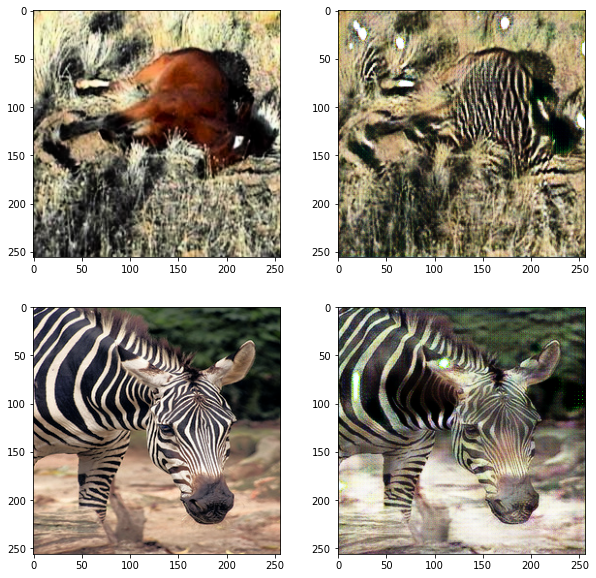

In [47]:
# 80 epochs
# select a batch of real samples
n_patch = d_model_A.output_shape[1]

# Generate real and fake samples
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

# Constrain values from [-1;1] to [0;1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeA = (X_fakeA + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0

# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Wince\AppData\Local\Temp\ipykernel_1360\2641846565.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


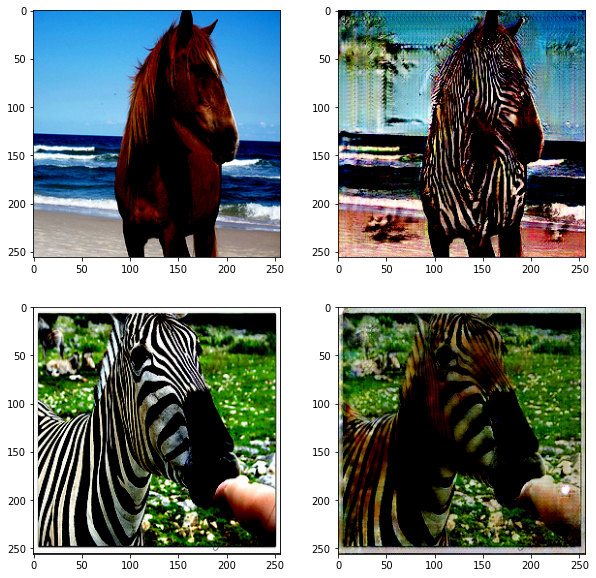

In [51]:
# 300 epochs and reduced LR
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
trainA, trainB = dataset
# select a batch of real samples
batch_size = 1
n_patch = d_model_A.output_shape[1]
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Wince\AppData\Local\Temp\ipykernel_11692\241925629.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


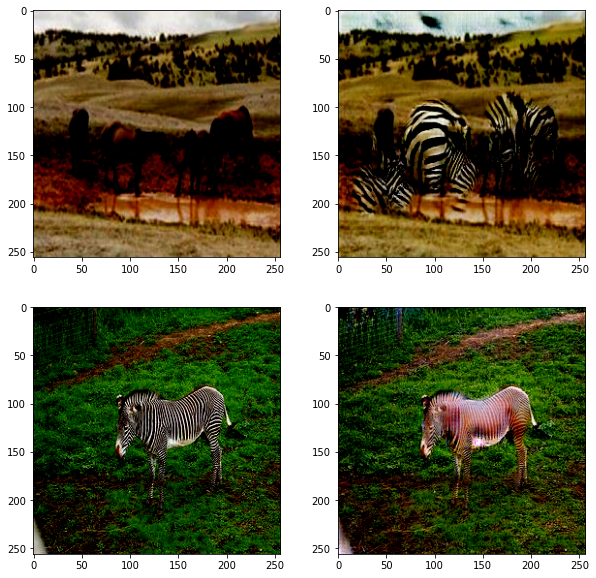

In [24]:
# 320 epochs and reduced LR
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
trainA, trainB = dataset
# select a batch of real samples
batch_size = 1
n_patch = d_model_A.output_shape[1]
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Wince\AppData\Local\Temp\ipykernel_11692\2858874675.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


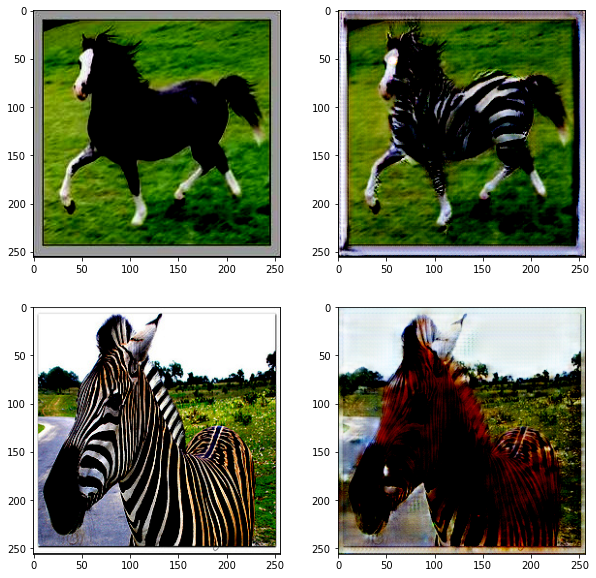

In [28]:
# 350 epochs and reduced LR
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
trainA, trainB = dataset
# select a batch of real samples
batch_size = 1
n_patch = d_model_A.output_shape[1]
X_realA, y_realA = generate_real_samples(trainA, 1, n_patch)
X_realB, y_realB = generate_real_samples(trainB, 1, n_patch)
X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update fakes from pool
f, ax = plt.subplots(2,2,figsize=(10,10))
#plt.subplot(221)
ax[0,0].imshow(X_realA[0])
#plt.subplot(222)
ax[0,1].imshow(X_fakeB[0])
#plt.subplot(223)
ax[1,0].imshow(X_realB[0])
#plt.subplot(224)
ax[1,1].imshow(X_fakeA[0])
f.show()